# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第28节 真 • 动态自适应双均线策略</b></font>
</center>

-----------------


作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

上一节讲解了选股策略与择时策略相互配合的示例，本节的内容将讲解择时策略中的经典策略双均线策略，以及它的优化版本动态自适应双均线策略。


首先导入本节需要使用的abupy中的模块： 

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import AbuDoubleMaBuy, AbuDoubleMaSell, ABuKLUtil, ABuSymbolPd
from abupy import AbuFactorCloseAtrNStop, AbuFactorAtrNStop, AbuFactorPreAtrNStop
from abupy import abu, ABuProgress, AbuMetricsBase, EMarketTargetType, nd

下面先获取沙盒数据中美股一年的数据，为之后的分析做数据准备：

In [3]:
# 使用沙盒内的美股做为回测目标
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 
                     'usGOOG', 'usWUBA', 'usVIPS']
kl_dict = {us_symbol[2:]: 
 ABuSymbolPd.make_kl_df(us_symbol, start='2014-07-26', end='2015-07-26') 
 for us_symbol in us_choice_symbols}

### 1. 传统的双均线择时策略

双均线策略是量化策略中经典的策略之一，其属于趋势跟踪策略，基本实现思想如下

1. 预设两条均线：比如一个ma=5，一个ma=60, 5的均线被称作快线，60的均线被称作慢线
2. 择时买入策略中当快线上穿慢线（ma5上穿ma60）称为形成金叉买点信号，买入股票
3. 择时卖出策略中当快线下穿慢线（ma5下穿ma60）称为形成死叉卖点信号，卖出股票

熟悉技术指标的朋友都知道比如macd，kdj等等依赖均线的技术指标，其核心思想都差不多。

下面使用abupy中的技术指标模块nd绘制一下上述文字描述，如下：

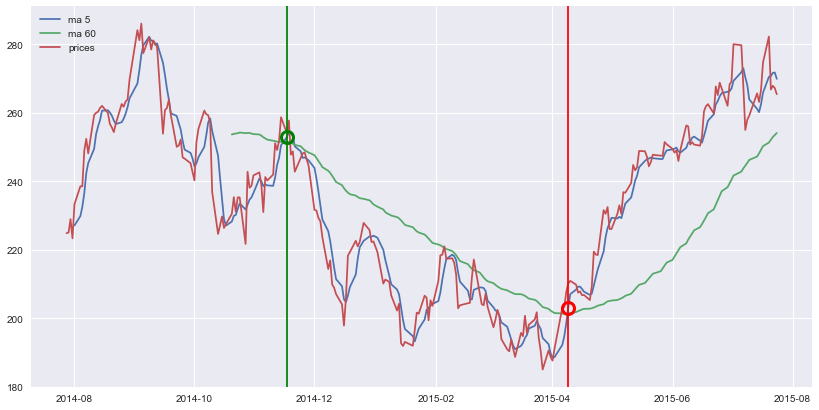

In [4]:
nd.ma.plot_ma_from_klpd(kl_dict['TSLA'], time_period=(5, 60), 
                        with_points_ext=pd.to_datetime('2015-04-09'), 
                        with_points=pd.to_datetime('2014-11-17'))

上图中可以看到

* 第一次ma5(蓝线)上穿ma60(绿线)形成金叉的时候，没能够继续上升趋势，马上ma5下穿了ma60形成死叉卖出信号
* 第二次（红竖线）发出金叉信号的时候持续了上升趋势

下面使用abupy中内置的双均线策略进行回测示例，如下：

买入后卖出的交易数量:34
买入后尚未卖出的交易数量:4
胜率:55.8824%
平均获利期望:15.3512%
平均亏损期望:-4.6467%
盈亏比:3.8120
策略收益: 32.0935%
基准收益: 15.0841%
策略年化收益: 16.0468%
基准年化收益: 7.5420%
策略买入成交比例:100.0000%
策略资金利用率比例:17.1377%
策略共执行504个交易日


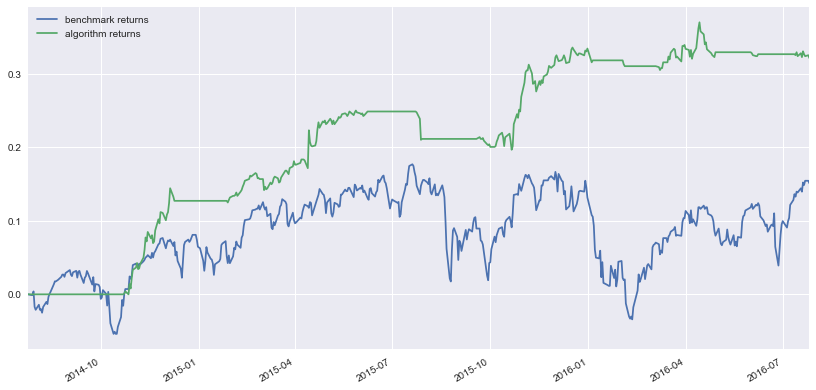

In [4]:
# 初始资金量
cash = 3000000
def run_loo_back(choice_symbols, ps=None, n_folds=2, start=None, end=None, only_info=False):
    """封装一个回测函数，返回回测结果，以及回测度量对象"""
    if choice_symbols[0].startswith('us'):
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US
    else:
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
    abu_result_tuple, _ = abu.run_loop_back(cash,
                                           buy_factors,
                                           sell_factors,
                                           ps,
                                           start=start,
                                           end=end,
                                           n_folds=n_folds,
                                           choice_symbols=choice_symbols)
    ABuProgress.clear_output()
    metrics = AbuMetricsBase.show_general(*abu_result_tuple, returns_cmp=only_info, 
                                only_info=only_info,
                                only_show_returns=True)
    return abu_result_tuple, metrics

# 买入双均线策略AbuDoubleMaBuy寻找金叉买入信号：ma快线＝5，ma慢线＝60
buy_factors = [{'fast': 5, 'slow': 60, 'class': AbuDoubleMaBuy}]
# 卖出双均线策略AbuDoubleMaSell寻找死叉卖出信号：ma快线＝5，ma慢线＝60，并行继续使用止盈止损基础策略
sell_factors = [{'fast': 5, 'slow': 60, 'class': AbuDoubleMaSell},
                {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
                 'class': AbuFactorAtrNStop},
                {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
                {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}]
# 开始回测
abu_result_tuple, metrics = run_loo_back(us_choice_symbols)

通过度量对象可视化可以发现择时生效买入因子都是ma5上穿ma60的金叉信号，卖出择时因子并行了4个策略，可以看到ma5下穿ma60的死叉信号生效比例也很高，如下：

买入择时生效因子分布：
AbuDoubleMaBuy:fast=5,slow=60    34
dtype: int64
卖出择时生效因子分布：
AbuDoubleMaSell:61                        11
AbuFactorAtrNStop:stop_win=3.0             6
AbuFactorCloseAtrNStop:close_atr_n=1.5    12
AbuFactorPreAtrNStop:pre_atr=1.5           5
dtype: int64


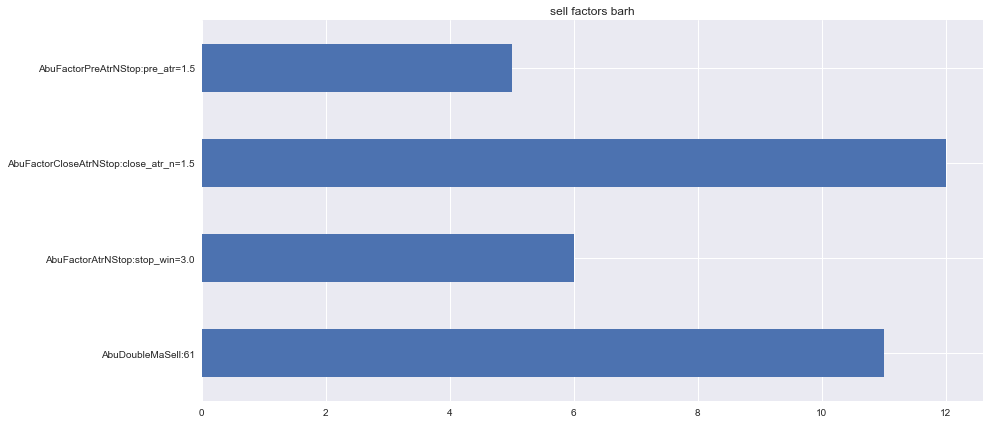

In [5]:
metrics.plot_buy_factors()
metrics.plot_sell_factors()

下面从交易单中筛选出所有tsla的交易结果，如下所示：

In [6]:
tsla_orders = abu_result_tuple.orders_pd[abu_result_tuple.orders_pd.symbol=='usTSLA']
tsla_orders

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result,profit_cg,profit_cg_hunder,keep_days
2014-11-18,20141118,257.750,1947.0,"AbuDoubleMaBuy:fast=5,slow=60",usTSLA,AbuAtrPosition,call,1.0,AbuDoubleMaSell:61,20141124,244.120,loss,None,81,-26537.61,-1,-0.0529,-5.2881,6
2015-04-10,20150410,210.325,2289.0,"AbuDoubleMaBuy:fast=5,slow=60",usTSLA,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_win=3.0,20150609,255.940,win,None,178,104412.74,1,0.2169,21.6879,60
2015-09-18,20150918,260.660,1697.0,"AbuDoubleMaBuy:fast=5,slow=60",usTSLA,AbuAtrPosition,call,1.0,AbuDoubleMaSell:61,20151001,242.815,loss,None,290,-30282.96,-1,-0.0685,-6.8461,13
2015-12-21,20151221,233.455,2052.0,"AbuDoubleMaBuy:fast=5,slow=60",usTSLA,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.5,20160105,223.445,loss,None,355,-20540.52,-1,-0.0429,-4.2878,15
2016-07-15,20160715,221.195,2109.0,"AbuDoubleMaBuy:fast=5,slow=60",usTSLA,AbuAtrPosition,call,1.0,,0,NaN,keep,None,496,NaN,0,NaN,NaN,427


通过nd模块的plot_ma_from_order接口可视化tsla交易单中的第一笔交易，可以发现这笔交易就是本节开始时示例的tsla第一次ma5(蓝线)上穿ma60(绿线)形成金叉且没能够继续上升趋势，马上ma5下穿了ma60形成死叉卖出信号的那笔交易。

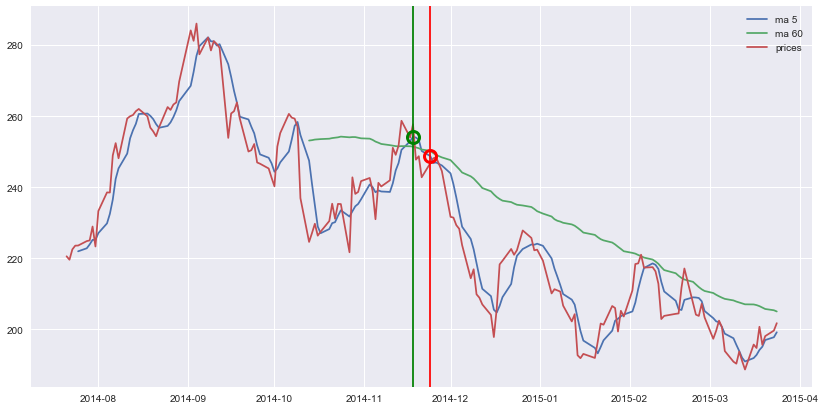

In [7]:
nd.ma.plot_ma_from_order(tsla_orders.iloc[0], time_period=(5, 60))

继续可视化tsla交易单中的第二笔交易，可以发现这笔交易就是本节开始时示例的tsla第二次ma5上穿ma60发出金叉信号且持续了上升趋势的那笔交易。

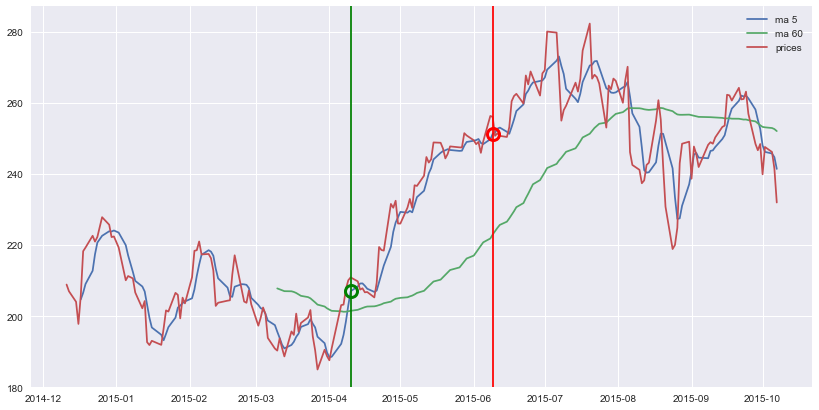

In [14]:
nd.ma.plot_ma_from_order(tsla_orders.iloc[1], time_period=(5, 60))

### 2. 真 • 动态自适应双均线策略

![](./image/zsg.jpg)


传统双均线策略当两根信号线差距比较大时，如上面ma5，ma60这种组合，属于迟钝金叉，即可能趋势以发生了很长时间甚至都快要结束的时候才能发出金叉买入信号，比如本节开始时绘制的tsla的两个金叉买入信号中的第一个信号。

那么如果调近两根均值的差距，比如使用ma5，ma20呢，下面绘制本节开始时绘制的tsla，ma参数改为5，20，如下：

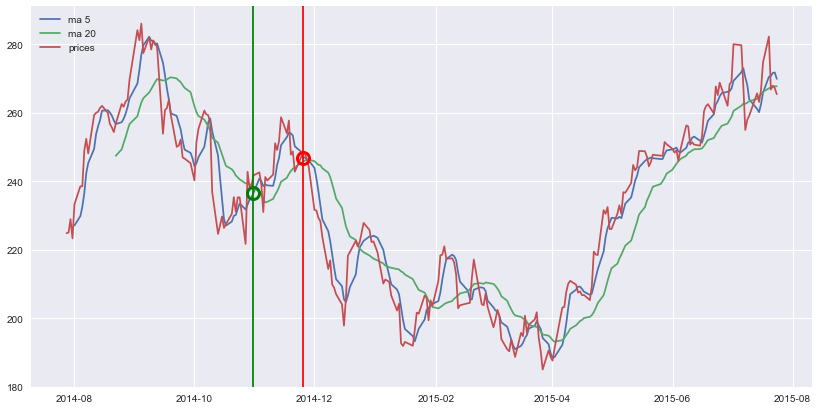

In [31]:
nd.ma.plot_ma_from_klpd(kl_dict['TSLA'], time_period=(5, 20), 
                        with_points_ext=pd.to_datetime('2014-11-25'), 
                        with_points=pd.to_datetime('2014-10-31'))

可以看到之前的金叉信号提前发出了，且死叉信号发出的也比较及时，这笔交易有一定的收益，但是注意观察其它的信号点可以发现产生了很多买卖信号，因为上面ma5，ma20这种组合，属于敏感金叉，这些信号中很多产生了失败的交易。

abupy中AbuDoubleMaBuy是动态自适应双均线策略，比如下面的参数中不传递快线值，只传递慢线值60，如下进行回测：

买入后卖出的交易数量:32
买入后尚未卖出的交易数量:6
胜率:59.3750%
平均获利期望:14.6188%
平均亏损期望:-4.8926%
盈亏比:4.0578
策略收益: 31.9865%
基准收益: 15.0841%
策略年化收益: 15.9933%
基准年化收益: 7.5420%
策略买入成交比例:100.0000%
策略资金利用率比例:19.8624%
策略共执行504个交易日


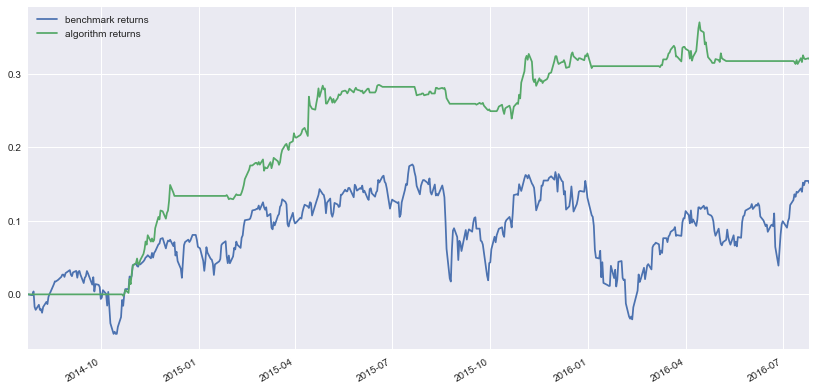

In [20]:
# 只传递慢线60，不传递快线参数为动态自适应快线值
buy_factors = [{'slow': 60, 'class': AbuDoubleMaBuy}]
abu_result_tuple, metrics = run_loo_back(us_choice_symbols)

下面可视化买入因子的生效分布，如下所示：

买入择时生效因子分布：
AbuDoubleMaBuy:fast=18,slow=60     4
AbuDoubleMaBuy:fast=3,slow=60      8
AbuDoubleMaBuy:fast=9,slow=60     20
dtype: int64


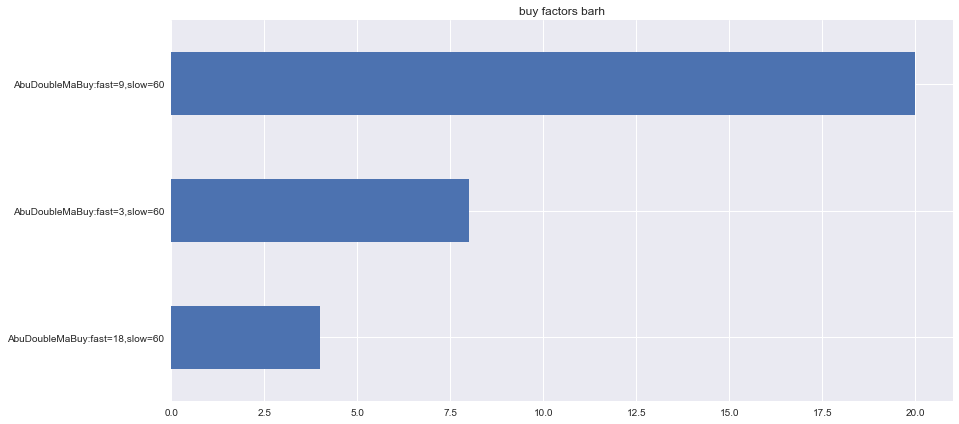

In [21]:
metrics.plot_buy_factors()

可以看到买入因子慢线仍然使用参数中传递的60，快线有3，9，18三个值，这三个值是以慢线数值为基数，结合大盘的走势计算出来的。

策略中动态计算快线的策略主要参考了大盘最近一个月走势震荡程度，动态决策快线的值：

1. 大盘最近一个月走势非常稳定：fast＝slow X 0.05 eg: slow=60->fast=60 X 0.05=3
2. 大盘最近一个月走势比较稳定：fast＝slow X 0.15 eg: slow=60->fast=60 X 0.15=9
3. 大盘最近一个月走势比较震荡：fast＝slow X 0.3 eg: slow=60->fast=60 X 0.3=18
4. 大盘最近一个月走势非常震荡：fast＝slow X 0.5 eg: slow=60->fast=60 X0.5=30
5. 择时周期内每一个月重新计算一次

具体实现以及如何判定大盘的震荡程度请自行阅读源代码

上面的双均线策略中的慢线依然是通过参数传递，下面示例慢线参数也动态自适应计算的回测，如下：

买入后卖出的交易数量:33
买入后尚未卖出的交易数量:5
胜率:63.6364%
平均获利期望:16.8128%
平均亏损期望:-7.9822%
盈亏比:3.4073
策略收益: 35.2705%
基准收益: 15.0841%
策略年化收益: 17.6353%
基准年化收益: 7.5420%
策略买入成交比例:100.0000%
策略资金利用率比例:18.7779%
策略共执行504个交易日


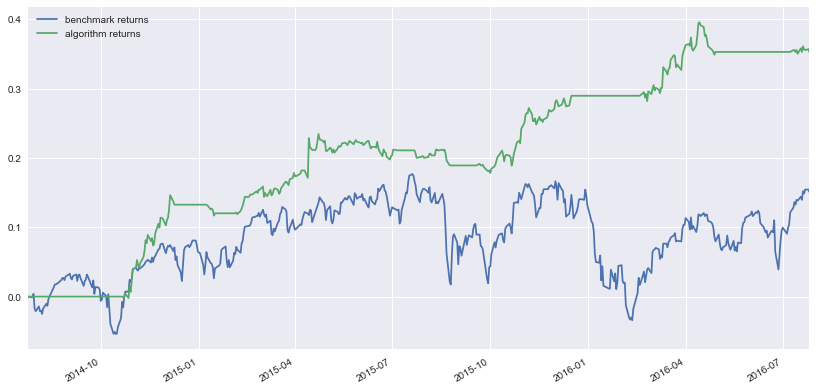

In [22]:
# 不传递任何参数，快线， 慢线都动态自适应
buy_factors = [{'class': AbuDoubleMaBuy}]
abu_result_tuple, metrics = run_loo_back(us_choice_symbols)

下面可视化买入因子的生效分布，如下所示：

买入择时生效因子分布：
AbuDoubleMaBuy:fast=12,slow=75     1
AbuDoubleMaBuy:fast=15,slow=100    3
AbuDoubleMaBuy:fast=15,slow=50     1
AbuDoubleMaBuy:fast=2,slow=25      1
AbuDoubleMaBuy:fast=2,slow=30      1
AbuDoubleMaBuy:fast=3,slow=50      1
AbuDoubleMaBuy:fast=30,slow=100    3
AbuDoubleMaBuy:fast=4,slow=25      2
AbuDoubleMaBuy:fast=4,slow=65      1
AbuDoubleMaBuy:fast=4,slow=70      1
AbuDoubleMaBuy:fast=4,slow=75      1
AbuDoubleMaBuy:fast=5,slow=100     3
AbuDoubleMaBuy:fast=5,slow=30      2
AbuDoubleMaBuy:fast=6,slow=20      1
AbuDoubleMaBuy:fast=6,slow=35      1
AbuDoubleMaBuy:fast=6,slow=40      4
AbuDoubleMaBuy:fast=7,slow=45      1
AbuDoubleMaBuy:fast=8,slow=25      1
AbuDoubleMaBuy:fast=8,slow=50      2
AbuDoubleMaBuy:fast=9,slow=55      2
dtype: int64


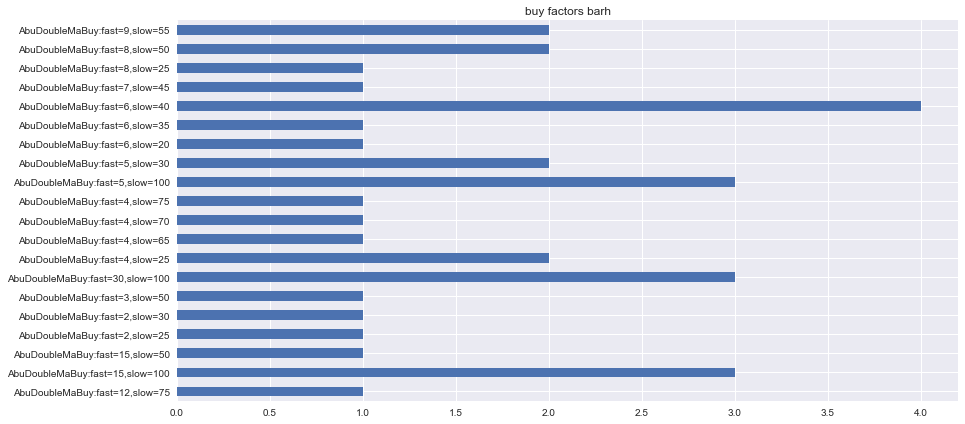

In [23]:
metrics.plot_buy_factors()

可以看到买入因子慢线的值从20到100不等，快线的值也从2到30不等。

策略中动态计算快线的策略和上述的方式相同，动态自适应慢线值主要依据重采样周期内的振幅值来确定，在第‘第10节 比特币, 莱特币的回测’中已经使用过resample_close_mean统计重采样周期内的振幅值，如下：

In [12]:
ABuKLUtil.resample_close_mean(kl_dict)

,TSLAresample,NOAHresample,SFUNresample,BIDUresample,AAPLresample,GOOGresample,WUBAresample,VIPSresample
5D,0.0295,0.0418,0.0443,0.0225,0.0172,0.0189,0.0356,0.0333
10D,0.0399,0.0650,0.0610,0.0237,0.0220,0.0226,0.0608,0.0415
21D,0.0580,0.1017,0.0805,0.0362,0.0293,0.0284,0.1013,0.0677
42D,0.0729,0.1762,0.1330,0.0374,0.0377,0.0344,0.1728,0.1121
60D,0.0852,0.1740,0.1483,0.0340,0.0471,0.0560,0.1506,0.0999
90D,0.1251,0.2683,0.1945,0.0619,0.0719,0.0664,0.1851,0.1207
120D,0.1401,0.3365,0.1627,0.0368,0.0842,0.0797,0.2263,0.1365


动态自适应慢线值要使用统计重采样周期内的振幅值 > 0.12的周期做为慢线，比如上面针对tsla即需要slow=90, 针对noah大概需要slow=30，sfun大概slow=40。

具体实现请阅读AbuDoubleMaBuy策略实现源代码

具体策略实现中要根据止盈止损的大小，策略周期长度期望等等来设置一些参数值比如上面的0.12和最大，最小采样周期等参数来辅助动态自适应快慢线值的确定，类似在‘第12节 机器学习与比特币示例’中说的求解一个方程组，如果所有的参数都是未知数，那么你怎么解出你需要的答案，所以一定要把一些变量变成常数值，然后通过这些常数值来确定更多的变量，最终解出你所关心的解。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)